# Imports

In [1]:
import sys
import importlib
import pandas as pd
import numpy as np
import numpy.random as npr
from scipy.stats import zscore as zscore
import matplotlib.pyplot as plt
import seaborn as sns
import ssm
from ssm.util import find_permutation
import connect_to_dj
from utils import set_rcParams
import queryBehavior as qb

npr.seed(0)

[2024-01-18 12:44:27,717][INFO]: Connecting ward5243user@vfsmphysiomdb01.fsm.northwestern.edu:3306
[2024-01-18 12:44:27,778][INFO]: Connected ward5243user@vfsmphysiomdb01.fsm.northwestern.edu:3306


Set up external storage at \\fsmresfiles.fsm.northwestern.edu\fsmresfiles\Basic_Sciences\Phys\PintoLab\_Dj_external\
Set up external storage at \\fsmresfiles.fsm.northwestern.edu\fsmresfiles\Basic_Sciences\Phys\PintoLab\_Dj_external\


# Set plotting params

In [2]:
set_rcParams.internationally_acclaimed_default_rcParams()

# Create DJ virtual module

In [3]:
VM = connect_to_dj.get_virtual_modules()

List of virtual modules:
['lab', 'subject', 'reference', 'procedure', 'behavior', 'session', 'eyetracking', 'pose_equipment', 'widefield_analysis', 'widefield', 'widefield_trial_df', 'equipment', 'twophoton', 'opto', 'testdb', 'pose_estimation', 'behavior_analysis', 'widefield_trial_dff']


# Fit two-input GLM-HMM to one session of data

## Get one example session of towers data

In [4]:
performance = pd.DataFrame((VM['behavior'].Performance & 'subject_fullname = "jlt6316_DrChuck"' & 'task = "TowersTaskSwitch"').fetch())

performance          = qb.rm_abort_session(performance)
all_maze_id          = performance['all_maze_id']
has_correct_mazes    = [these_mazes.tolist() == [[4], [11], [12]] for these_mazes in all_maze_id]
performance          = performance.loc[has_correct_mazes, :]
has_good_performance = [this_perf[2][0] > 0.55 for this_perf in performance['proportion_correct']]
performance          = performance.loc[has_good_performance, :]
performance          = performance.reset_index(drop=True)

# performance.head(112)

In [5]:
# Fetch restrictions
subject_fullname = 'jlt6316_DrChuck'
session_date     = '2023-06-20'
session_number   = 1
task             = 'TowersTaskSwitch'
maze_id          = 11
out_vars         = [
  'maze_id',
  'trial_type',
  'choice',
  'num_towers_left',
  'num_towers_right',
  'num_towers_delta',
  'trial_duration',
  'excess_travel',
  'mean_speed_stem',
  'block_performance',
  'is_first_trial_of_block']

restriction = qb.genQ(subject_fullname = subject_fullname, session_date = session_date, session_number = session_number, task = task, maze_id = maze_id, out_vars = out_vars)
trial_q     = qb.buildTrialQuery(restriction)

# Fetch data
data = pd.DataFrame(trial_q.fetch())
data = data.drop(data[data['choice'] == 'nil'].index)
data = data.reset_index(drop = True)

## Input Driven Observations ("GLM-HMM")

Compared to the model considered in the notebook ["2 Input Driven HMM"](https://github.com/lindermanlab/ssm/blob/master/notebooks/2%20Input%20Driven%20HMM.ipynb), Ashwood et al. (2020) assumes a stationary transition matrix where transition probabilities *do not* depend on external inputs. However, observation probabilities now *do* depend on external covariates according to:


for $c \neq C$:
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{\exp\{w_{kc}^\mathsf{T} u_t\}}
{1+\sum_{c'=1}^{C-1} \exp\{w_{kc'}^\mathsf{T} u_t\}}
\end{align}
$$

and for $c = C$:
$$
\begin{align}
\Pr(y_t = c \mid z_{t} = k, u_t, w_{kc}) = 
\frac{1}
{1+\sum_{c'=1}^{C-1} \exp\{w_{kc'}^\mathsf{T} u_t\}}
\end{align}
$$

where $c \in \{1, ..., C\}$ indicates the categorical class for the observation, $u_{t} \in \mathbb{R}^{M}$ is the set of input covariates, and $w_{kc} \in \mathbb{R}^{M}$ is the set of input weights associated with state $k$ and class $c$. These weights, along with the transition matrix and initial state probabilities, will be learned.

In Ashwood et al. (2020), $C = 2$ as $y_{t}$ represents the binary choice made by an animal during a 2AFC (2-Alternative Forced Choice) task. The above equations then reduce to:

$$
\begin{align}
\Pr(y_t = 0 \mid z_{t} = k, u_t, w_{k}) = 
\frac{\exp\{w_{k}^\mathsf{T} u_t\}}
{1 + \exp\{w_{k}^\mathsf{T} u_t\}} = \frac{1}
{1 + \exp\{-w_{k}^\mathsf{T} u_t\}}.
\end{align}
$$

$$
\begin{align}
\Pr(y_t = 1 \mid z_{t} = k, u_t, w_{k}) = 
\frac{1}
{1 + \exp\{w_{k}^\mathsf{T} u_t\}}.
\end{align}
$$

and only a single weight vector, $w_{k}$, is associated with each state.

## Initialize GLM-HMM

In [6]:
# Set the parameters of the GLM-HMM
num_states     = 2    # number of discrete states
obs_dim        = 1    # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim      = 2    # input dimensions

# Make a GLM-HMM
glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

## Organise inputs

In [7]:
num_sess          = 1
input             = np.ones((num_sess, len(data), input_dim))
input[0, :, 1]    = data['num_towers_delta'].to_numpy(dtype=float)
# input[0, :, 0]    = zscore(data['num_towers_delta'].to_numpy(dtype=float), nan_policy='omit')
input             = list(input) 
chose_right       = np.zeros((len(data), 1))
chose_right[:, 0] = np.array((data['choice'] == 'R'))
chose_right       = chose_right.astype(int)
chose_right       = [chose_right]

## Fit GLM-HMM

In [8]:
N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = glmhmm.fit(chose_right, inputs=input, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

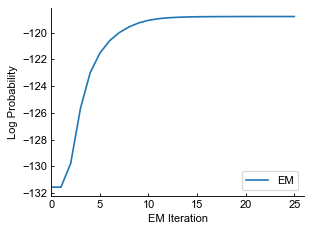

In [9]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

## Inferred latent states

In [10]:
glmhmm.most_likely_states(chose_right[0], input=input[0])

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [11]:
-glmhmm.observations.params

array([[[ 1.95665322, -0.04032263]],

       [[-0.16901623,  0.67513453]]])

## Transition probabilities

In [12]:
trans_mat = np.exp(glmhmm.transitions.log_Ps)
trans_mat

array([[0.75676255, 0.24323745],
       [0.04650257, 0.95349743]])

## Posterior state probabilities

In [13]:
# Get expected states:
posterior_probs = [glmhmm.expected_states(data=data, input=input)[0]
                for data, input
                in zip(chose_right, input)]

Text(0, 0.5, 'p (state)')

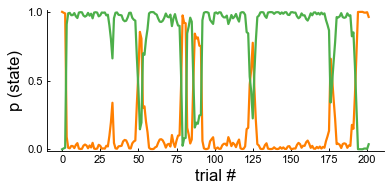

In [14]:
colors  = ['#ff7f00', '#4daf4a', '#377eb8']
fig     = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=colors[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p (state)", fontsize = 15)

## Fit GLM-HMM and perform recovery analysis: Maximum A Priori Estimation

Above, we performed Maximum Likelihood Estimation to retrieve the generative parameters of the GLM-HMM in simulated data. In the small data regime, where we do not have many trials available to us, we may instead want to perform Maximum A Priori (MAP) Estimation in order to incorporate a prior term and restrict the range for the best fitting parameters. Unfortunately, what is meant by 'small data regime' is problem dependent and will be affected by the number of states in the generative GLM-HMM, and the specific parameters of the generative model, amongst other things. In practice, we may perform both Maximum Likelihood Estimation and MAP estimation and compare the ability of the fit models to make predictions on held-out data (see Section 5 on Cross-Validation below).  

The prior we consider for the GLM-HMM is the product of a Gaussian prior on the GLM weights, $W$, and a Dirichlet prior on the transition matrix, $A$:

$$
\begin{align}
\Pr(W, A) &= \mathcal{N}(W|0, \Sigma) \Pr(A|\alpha) \\&= \mathcal{N}(W|0, diag(\sigma^{2}, \cdots, \sigma^{2})) \prod_{j=1}^{K} \dfrac{1}{B(\alpha)} \prod_{k=1}^{K} A_{jk}^{\alpha -1}
\end{align}
$$

There are two hyperparameters controlling the strength of the prior: $\sigma$ and $\alpha$.  The larger the value of $\sigma$ and if $\alpha = 1$, the more similar MAP estimation will become to Maximum Likelihood Estimation, and the prior term will become an additive offset to the objective function of the GLM-HMM that is independent of the values of $W$ and $A$.  In comparison, setting $\sigma = 2$ and $\alpha = 2$ will result in the prior no longer being independent of $W$ and $\alpha$.  

In order to perform MAP estimation for the GLM-HMM with `ssm`, the new syntax is:

```python
ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
             observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))
```

where `prior_sigma` is the $\sigma$ parameter from above, and `prior_alpha` is the $\alpha$ parameter.

In [15]:
# Instantiate GLM-HMM and set prior hyperparameters
prior_sigma = 2
prior_alpha = 2
map_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
             observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
             transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

In [16]:
# Fit GLM-HMM with MAP estimation:
_ = map_glmhmm.fit(chose_right, inputs=input, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

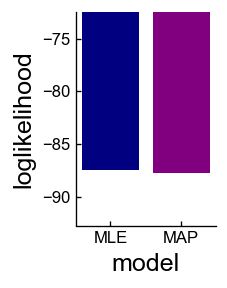

In [17]:
mle_final_ll = glmhmm.log_likelihood(chose_right, inputs=input) 
map_final_ll = map_glmhmm.log_likelihood(chose_right, inputs=input) 

# Plot these values
fig = plt.figure(figsize=(2, 2.5), dpi=120, facecolor='w', edgecolor='k')
loglikelihood_vals = [mle_final_ll, map_final_ll]
colors = ['Navy', 'Purple']
for z, occ in enumerate(loglikelihood_vals):
  plt.bar(z, occ, width = 0.8, color = colors[z])
  plt.ylim((map_final_ll-5, mle_final_ll+15))
  plt.xticks([0, 1], ['MLE', 'MAP'], fontsize = 10)
  plt.xlabel('model', fontsize = 15)
  plt.ylabel('loglikelihood', fontsize=15)

## Cross-validation

Use a few other sessions to test the performance for MLE and MAP results 

In [18]:
# Fetch restrictions
subject_fullname = 'jlt6316_DrChuck'
session_date     = ['2023-06-13', '2023-06-14', '2023-06-15', '2023-06-16', '2023-06-21']
session_number   = 1
task             = 'TowersTaskSwitch'
maze_id          = 11
out_vars         = [
  'maze_id',
  'trial_type',
  'choice',
  'num_towers_left',
  'num_towers_right',
  'num_towers_delta',
  'trial_duration',
  'excess_travel',
  'mean_speed_stem',
  'block_performance',
  'is_first_trial_of_block']

restriction = qb.genQ(subject_fullname = subject_fullname, session_date = session_date, session_number = session_number, task = task, maze_id = maze_id, out_vars = out_vars)
trial_q     = qb.buildTrialQuery(restriction)

# Fetch data
test_data = pd.DataFrame(trial_q.fetch())
test_data = data.drop(data[data['choice'] == 'nil'].index)
test_data = data.reset_index(drop = True)
test_data

,subject_fullname,session_date,session_number,task,protocol_id,trial_id,maze_id,trial_type,choice,num_towers_right,num_towers_left,num_towers_delta,trial_duration,excess_travel,mean_speed_stem,block_performance,is_first_trial_of_block
0,jlt6316_DrChuck,2023-06-20,1,TowersTaskSwitch,10,16,11,L,L,1,4,-3,8.95946,-0.155833,59.2039,0.750000,1
1,jlt6316_DrChuck,2023-06-20,1,TowersTaskSwitch,10,17,11,L,R,2,4,-2,7.82561,-0.155717,65.6065,0.750000,0
2,jlt6316_DrChuck,2023-06-20,1,TowersTaskSwitch,10,18,11,L,R,3,10,-7,7.55062,-0.164314,59.1442,0.750000,0
3,jlt6316_DrChuck,2023-06-20,1,TowersTaskSwitch,10,19,11,L,L,1,5,-4,8.54246,-0.138767,58.7619,0.750000,0
4,jlt6316_DrChuck,2023-06-20,1,TowersTaskSwitch,10,20,11,L,L,2,7,-5,7.12581,-0.170842,64.4112,0.750000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,jlt6316_DrChuck,2023-06-20,1,TowersTaskSwitch,10,326,11,L,R,0,7,-7,7.08395,-0.168822,61.0476,0.111111,0
198,jlt6316_DrChuck,2023-06-20,1,TowersTaskSwitch,10,327,11,L,R,0,2,-2,7.92580,-0.163908,58.5789,0.111111,0
199,jlt6316_DrChuck,2023-06-20,1,TowersTaskSwitch,10,328,11,L,R,3,5,-2,7.79051,-0.169301,54.0097,0.111111,0
200,jlt6316_DrChuck,2023-06-20,1,TowersTaskSwitch,10,329,11,L,R,2,7,-5,8.56738,-0.167854,47.7390,0.111111,0


## Organise test inputs

In [19]:
num_sess               = 1
test_input             = np.ones((num_sess, len(test_data), input_dim))
test_input[0, :, 1]    = data['num_towers_delta'].to_numpy(dtype=float)
test_input             = list(test_input) 
test_chose_right       = np.zeros((len(test_data), 1))
test_chose_right[:, 0] = np.array((test_data['choice'] == 'R'))
test_chose_right       = test_chose_right.astype(int)
test_chose_right       = [test_chose_right]

## Compare likelihood of test_choices for model fit with MLE and MAP

In [20]:
mle_test_ll = glmhmm.log_likelihood(test_chose_right, inputs=test_input) 
map_test_ll = map_glmhmm.log_likelihood(test_chose_right, inputs=test_input) 

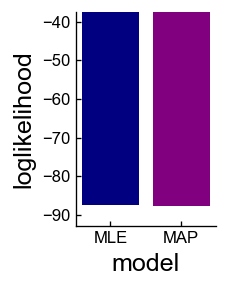

In [21]:
fig                     = plt.figure(figsize=(2, 2.5), dpi=120, facecolor='w', edgecolor='k')
test_loglikelihood_vals = [mle_test_ll, map_test_ll]
colors                  = ['Navy', 'Purple']
for z, occ in enumerate(test_loglikelihood_vals):
  plt.bar(z, occ, width = 0.8, color = colors[z])
  plt.ylim((map_test_ll-5, mle_test_ll+50))
  plt.xticks([0, 1], ['MLE', 'MAP'], fontsize = 10)
  plt.xlabel('model', fontsize = 15)
  plt.ylabel('loglikelihood', fontsize=15)

## Compare fits across multiple sessions

### Select a list of sessions

In [22]:
session_list = (VM['session'].Session & performance).fetch('KEY')

In [193]:
# Initialize weight storage
fit_ll_x_sessions          = []
weights_x_sessions         = []
posterior_probs_x_sessions = []
states_x_sessions          = []
has_data                   = np.full(len(session_list), True)
has_ambioiguous_states     = np.full(len(session_list), False)

# Initialize GLM-HMM
num_states      = 2    # number of discrete states
obs_dim         = 1    # number of observed dimensions
num_categories  = 2    # number of categories for output
input_dim       = 2    # input dimensions

# Loop over sessions
for iSession, session_key in enumerate(session_list):

  # Fetch data
  maze_id  = 11
  out_vars = [
    'maze_id',
    'trial_type',
    'choice',
    'num_towers_left',
    'num_towers_right',
    'num_towers_delta',
    'trial_duration',
    'excess_travel',
    'mean_speed_stem',
    'block_performance',
    'is_first_trial_of_block']

  # Fetch data
  data = pd.DataFrame((VM['behavior'].TowersSessionTrial & session_key & qb.genFilter('maze_id', maze_id)).proj(*out_vars).fetch())
  data = data.drop(data[data['choice'] == 'nil'].index)
  data = data.reset_index(drop=True)

  # Store empty list if there is no data
  if len(data) == 0:
    has_data[iSession] = False
    fit_ll_x_sessions.append([])
    weights_x_sessions.append([])
    posterior_probs_x_sessions.append([])
    states_x_sessions.append([])
    continue

  # Organize data
  num_sess          = 1
  input             = np.ones((num_sess, len(data), input_dim))
  input[0, :, 1]    = data['num_towers_delta'].to_numpy(dtype=float)
  input             = list(input) 
  chose_right       = np.zeros((len(data), 1))
  chose_right[:, 0] = np.array((data['choice'] == 'R'))
  chose_right       = chose_right.astype(int)
  chose_right       = [chose_right]

  # Fit GLM-HMM
  glmhmm_two_input = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")
  n_iters          = 200
  glmhmm_two_input.fit(chose_right, inputs=input, method="em", num_iters=N_iters, tolerance=10**-4)
  fit_ll           = glmhmm_two_input.log_likelihood(chose_right, inputs=input)
  weights          = np.squeeze(-glmhmm_two_input.observations.params)
  posterior_probs  = glmhmm_two_input.expected_states(data=chose_right[0], input=input[0])[0]
  states           = glmhmm_two_input.most_likely_states(chose_right[0], input=input[0])

  # Store likelihood and weights
  fit_ll_x_sessions.append(fit_ll)
  weights_x_sessions.append(weights)
  posterior_probs_x_sessions.append(posterior_probs)
  states_x_sessions.append(states)

  # # Mark sessions that are confused
  max_weight_idx = np.argmax(np.abs(weights), axis=0)
  if max_weight_idx[0] == max_weight_idx[1]:
    has_ambioiguous_states[iSession] = True
    
  # Print Progress
  print('Finished session ' + str(iSession+1) + ' of ' + str(len(session_list)))
  
  

  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 1 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 2 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 3 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 4 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 5 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 6 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 7 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 8 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 9 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 10 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 11 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 12 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 13 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 14 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 15 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 16 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 17 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 18 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 19 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 20 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 21 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 22 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 23 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 24 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 25 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 26 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 27 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 28 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 29 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 30 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 31 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 32 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 33 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 35 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 36 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 37 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 38 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 39 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 40 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 41 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 42 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 43 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 44 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 45 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 46 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 47 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 48 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 49 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 50 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 51 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 52 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 53 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 54 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 55 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 56 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 57 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 58 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 59 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 60 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 61 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 62 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 63 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 64 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 65 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 66 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 67 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 68 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 69 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 70 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 71 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 72 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 73 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 74 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 75 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 76 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 77 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 78 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 79 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 80 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 81 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 82 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 83 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 84 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 85 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 86 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 87 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 88 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 89 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 90 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 91 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 92 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 93 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 94 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 95 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 96 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 97 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 98 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 99 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 100 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 101 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 102 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 103 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 104 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 105 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 106 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 107 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 108 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 109 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 110 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 111 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 112 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 113 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 114 of 115


  0%|          | 0/200 [00:00<?, ?it/s]

Finished session 115 of 115


### Visualize fits

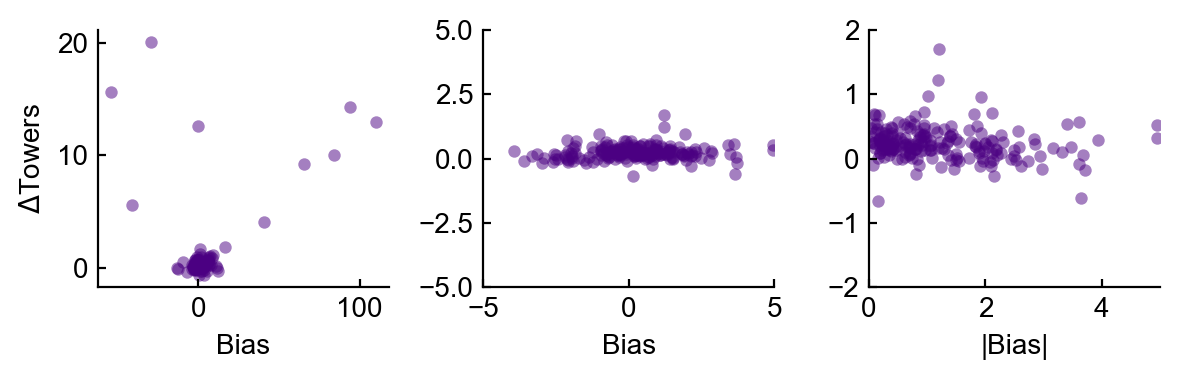

In [256]:
# Plot the weights against each other as a scatter plot
concat_weights = [weights_session for idx_session, weights_session in enumerate(weights_x_sessions) if has_data[idx_session]]
concat_weights = np.concatenate(concat_weights, axis=0)
fig, axs = plt.subplots(figsize=(6,2), nrows=1, ncols=3, dpi=200, facecolor='w', edgecolor='k')
axs[0].scatter(concat_weights[:, 0], concat_weights[:, 1], marker='o', color='indigo', linewidths=0, alpha=0.5, s=20)
axs[0].set_xlabel('Bias', fontsize=10)
axs[0].set_ylabel(r'$\Delta$Towers', fontsize=10)

# Plot the same as above, but zoomed in on the origin
axs[1].scatter(concat_weights[:, 0], concat_weights[:, 1], marker='o', color='indigo', linewidths=0, alpha=0.5, s=20)
axs[1].set_xlim((-5, 5))
axs[1].set_ylim((-5, 5))
axs[1].set_xlabel('Bias', fontsize=10)

# Plot the same as above, but take the absolute value of bias weights
axs[2].scatter(np.abs(concat_weights[:, 0]), concat_weights[:, 1], marker='o', color='indigo', linewidths=0, alpha=0.5, s=20)
axs[2].set_xlabel('|Bias|', fontsize=10)
axs[2].set_xlim((0, 5))
axs[2].set_ylim((-2, 2))

# Save figure as pdf
fig.savefig('glmhmm_weights.pdf', bbox_inches='tight')


### Visualize corelations between states with larger absolute weights and performance in ambiguous states

[2024-01-19 11:38:25,701][WARNING]: MySQL server has gone away. Reconnecting to the server.


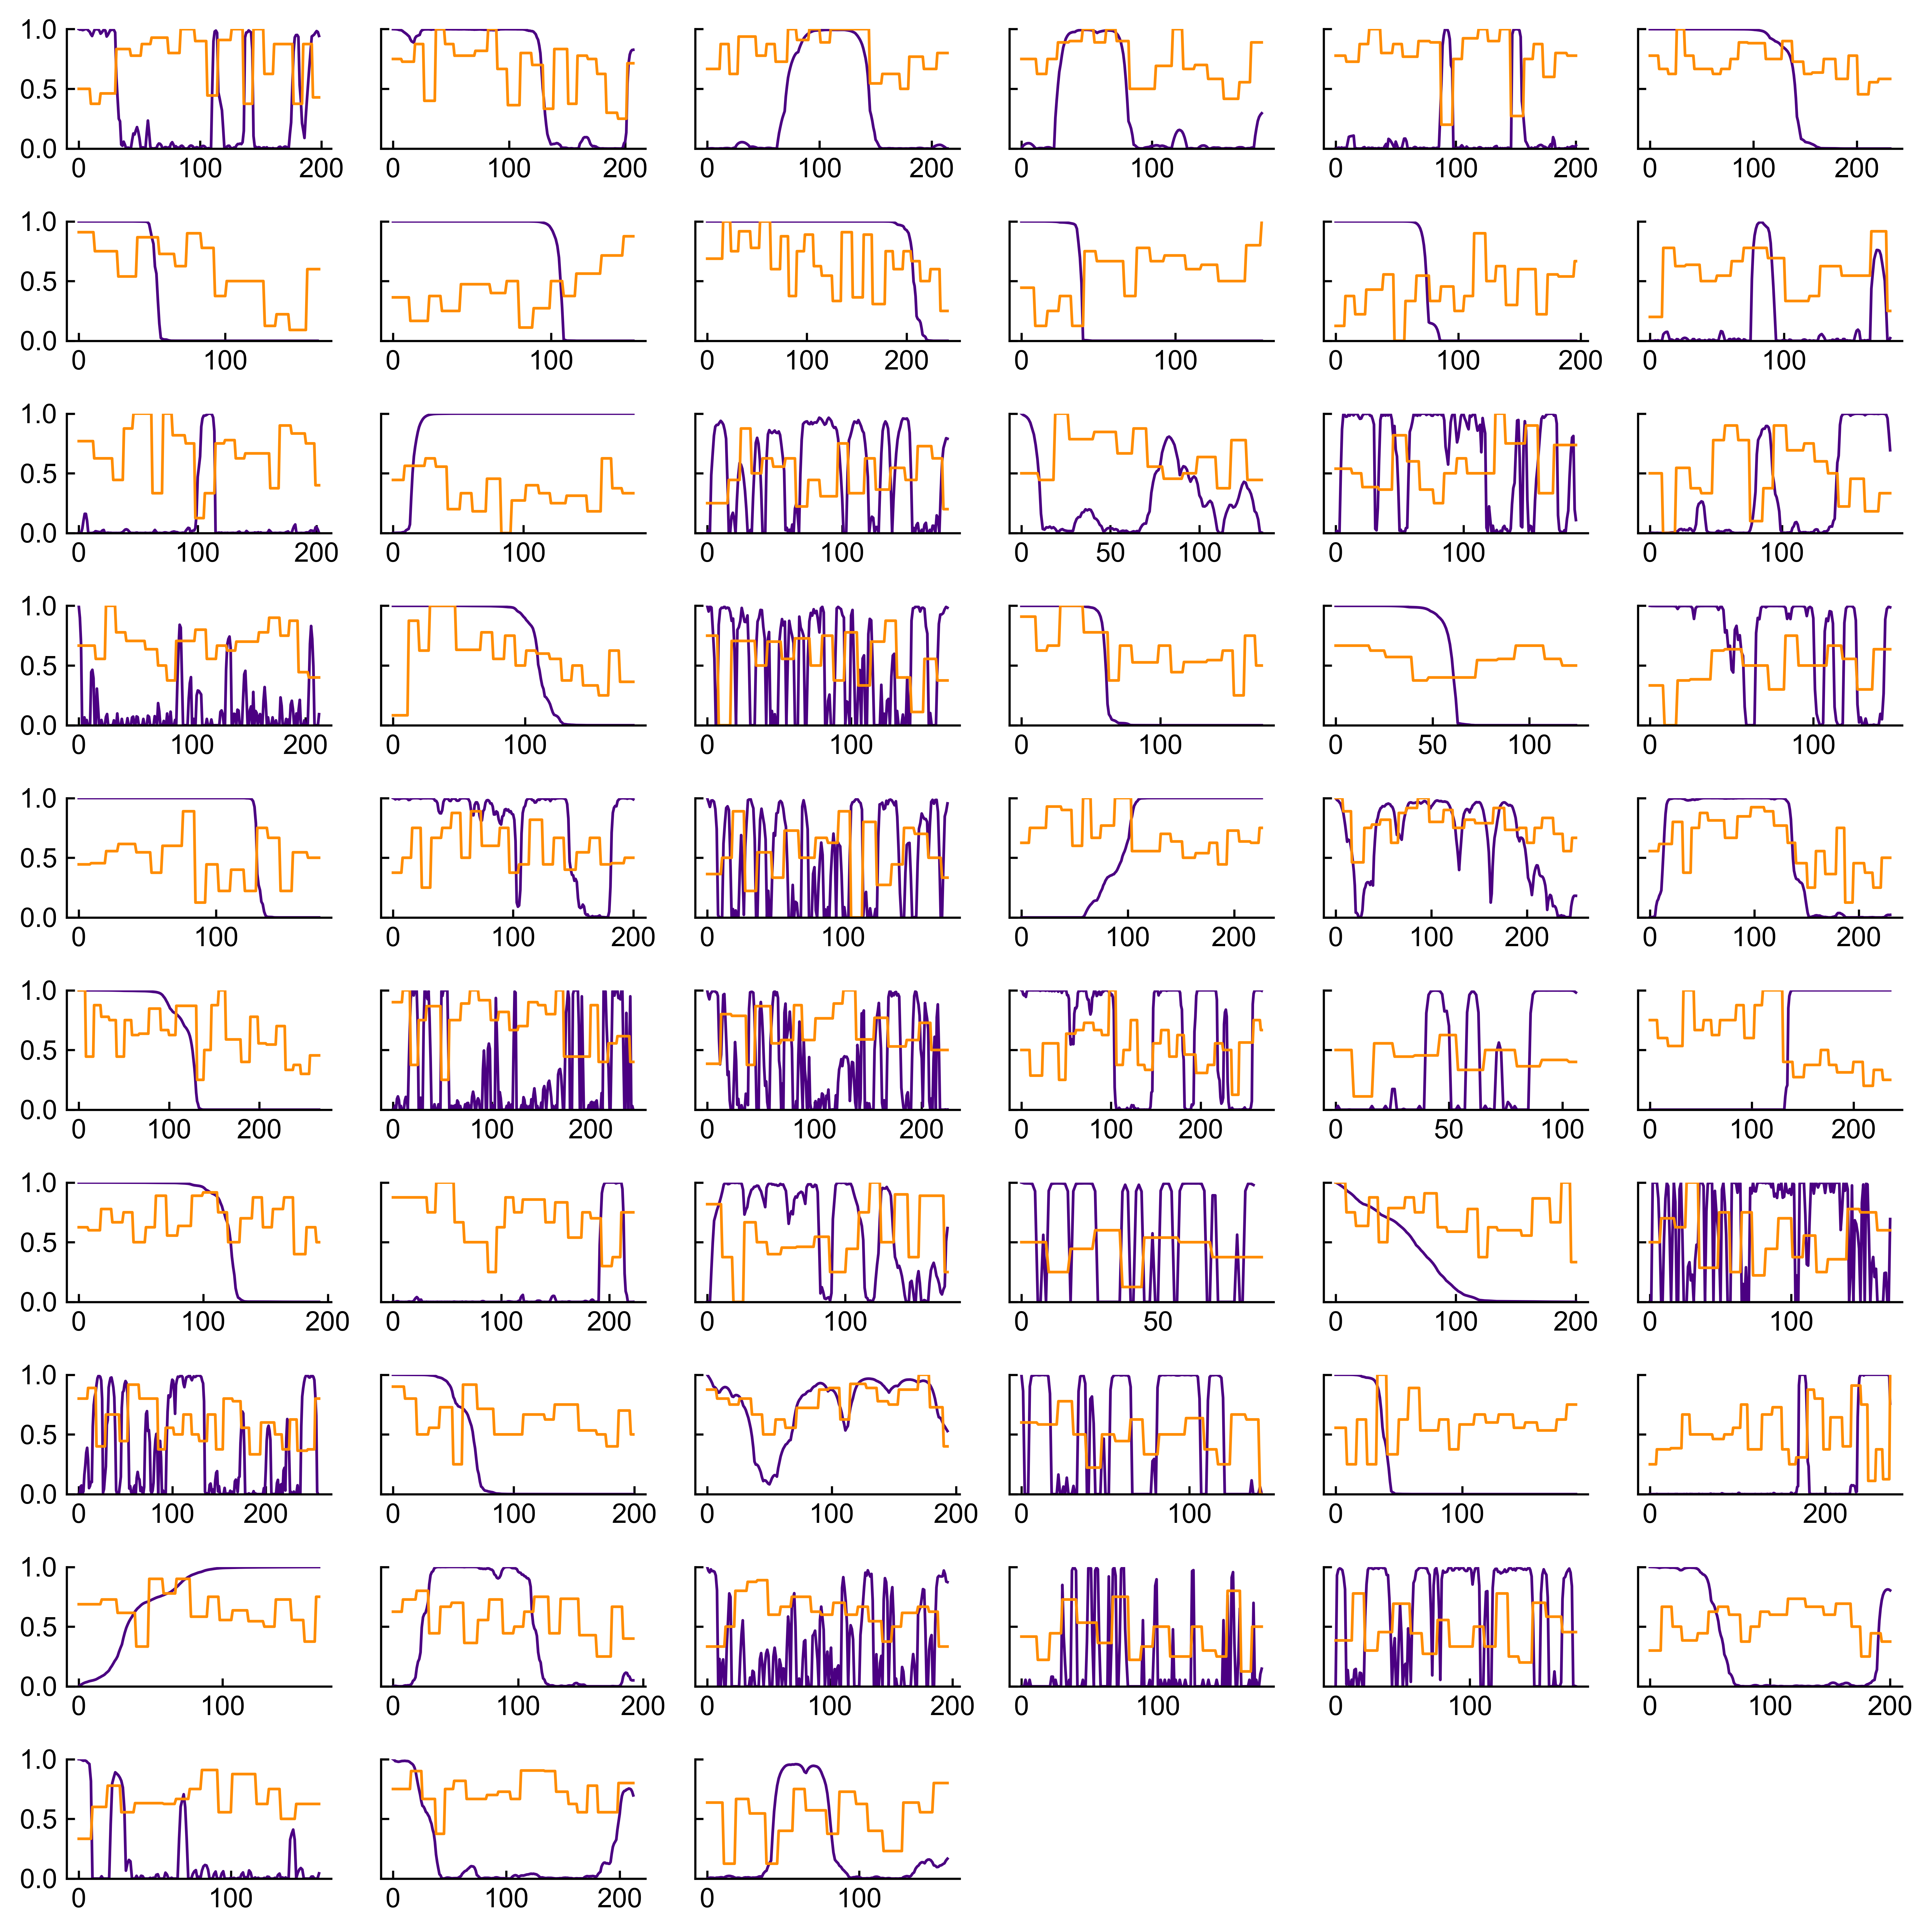

In [228]:
# Find indices into the original session list that has ambiguous states
ambiguous_session_inds = np.where(has_ambioiguous_states & has_data)[0]
num_amgiguous_sessions = len(ambiguous_session_inds)

# Distribute ambiguous sessions across subplots with roughly equal number of rows and columns
num_rows = 10
num_cols = 6

# Initialize subplots
fig, axs = plt.subplots(figsize=(10, 10), nrows=num_rows, ncols=num_cols, dpi=600, facecolor='w', edgecolor='k', sharey=True)

# Plot each session with ambiguous states in a separate subplot
for idx_axs, ax in enumerate(axs.flatten()):

  if idx_axs >= num_amgiguous_sessions:
    ax.set_visible(False)
    continue

  else:
    ambiguous_session_ind = ambiguous_session_inds[idx_axs]

    # Weights of the selected session
    weights = weights_x_sessions[ambiguous_session_ind]

    # Index of the state that has larger absolute towers weight
    max_weight_idx = np.argmax(np.abs(weights[:, 1]))
    
    # Posteriors probabilities of of the max weight state
    posterior_probs = posterior_probs_x_sessions[ambiguous_session_ind][:, max_weight_idx]

    # Fetch block performance of this session
    session_key = session_list[ambiguous_session_ind]
    maze_id = 11
    block_performance = (VM['behavior'].TowersSessionTrial & session_key & qb.genFilter('maze_id', maze_id)).fetch('block_performance')

    # Plot the posterior probabilities and block performance
    ax.plot(posterior_probs, color='indigo', linewidth=1)
    ax.plot(block_performance, color='darkorange', linewidth=1)
    ax.set_ylim((0, 1))

# # Save figure as pdf
# fig.savefig('ambiguous_sessions.pdf', transparent=True, bbox_inches='tight', dpi=600)

# Fit three-input GLM-HMM to one session

## Fetch data

In [ ]:
# Fetch restrictions
subject_fullname = 'jlt6316_DrChuck'
session_date     = '2023-06-20'
session_number   = 1
task             = 'TowersTaskSwitch'
out_vars         = [
  'maze_id',
  'trial_type',
  'choice',
  'num_towers_left',
  'num_towers_right',
  'num_towers_delta',
  'trial_duration',
  'excess_travel',
  'mean_speed_stem',
  'block_performance',
  'is_first_trial_of_block']

restriction = qb.genQ(subject_fullname = subject_fullname, session_date = session_date, session_number = session_number, task = task, out_vars = out_vars)
trial_q     = qb.buildTrialQuery(restriction)

# Fetch data
data = pd.DataFrame(trial_q.fetch())

# Generate choice history matrix
prev_choice         = qb.make_choice_hist(data, num_prev_trial=1)
data['prev_choice'] = prev_choice

# Select only maze 11 trials
data = data[data['maze_id'] == 11]
data = data.reset_index(drop = True)

## Initialize GLM-HMM

In [ ]:
# Set the parameters of the GLM-HMM
num_states     = 2    # number of discrete states
obs_dim        = 1    # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim      = 3    # input dimensions

# Make a GLM-HMM
glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

## Organize inputs

In [31]:
num_sess          = 1
input             = np.ones((num_sess, len(data), input_dim))
input[0, :, 1]    = data['num_towers_delta'].to_numpy(dtype=float)
input[0, :, 2]    = data['prev_choice'].to_numpy(dtype=int)
input             = list(input) 
chose_right       = np.zeros((len(data), 1))
chose_right[:, 0] = np.array((data['choice'] == 'R'))
chose_right       = chose_right.astype(int)
chose_right       = [chose_right]

## Fit GLM-HMM

In [32]:
N_iters = 200 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll  = glmhmm.fit(chose_right, inputs=input, method="em", num_iters=N_iters, tolerance=10**-4)

  0%|          | 0/200 [00:00<?, ?it/s]

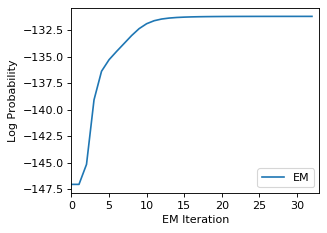

In [33]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

## Inferred latent states

In [34]:
glmhmm.most_likely_states(chose_right[0], input=input[0])

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [35]:
-glmhmm.observations.params

array([[[-0.19644575,  0.74135667, -0.62127054]],

       [[ 5.73292719,  0.10399191,  5.32965768]]])